### Forecasting time series data with seasonal ARIMA model

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.api import adfuller, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Download and read the data

milk_file = Path('/Users/sm/Documents/Time-Series-Analysis/TSAwPCB/chapter_10/milk_production.csv')
milk_data = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [3]:
# Check the data

milk_data.head(10)

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
1962-06-01,697
1962-07-01,640
1962-08-01,599
1962-09-01,568


In [4]:
milk_data.describe()

,production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [5]:
# Check if the index is of datetime type

milk_data.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='month', length=168, freq=None)

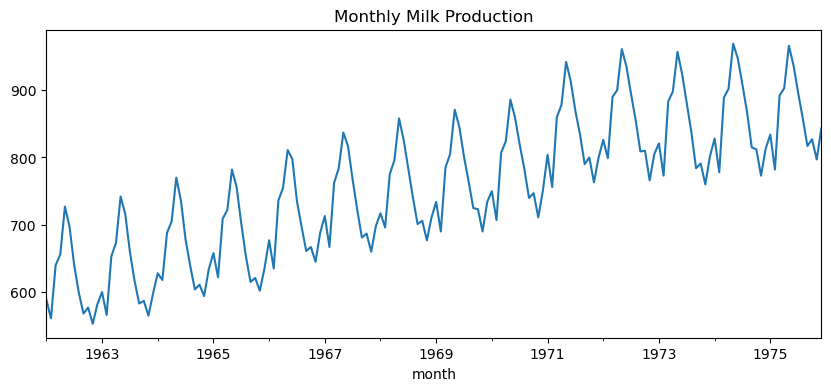

In [6]:
# Visualize the data

fig, ax = plt.subplots(figsize=(10, 4))
milk_data.plot(title='Monthly Milk Production', legend=False, ax=ax)
plt.show()

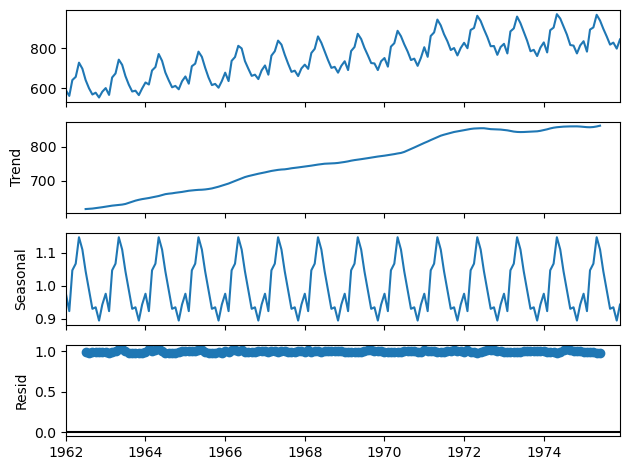

In [7]:
# The dataset has trend and seasonal components. We can decompose the dataset to ovserve the components separately.

decomposed = seasonal_decompose(milk_data, period=12, model='multiplicative')
decomposed.plot()
plt.show()

In [8]:
# We can remove seasonal component (12 months) of the data 

milk_diff_12 = milk_data.diff(12).dropna()

In [9]:
# We check the stationarity of the deseasoned time series

adf = adfuller(milk_diff_12)[1:3]

if adf[0] < 0.05:
    print('Time series is stationary')
    print(f"p-value: {adf[0]}")
else:
    print('Time series is non-stationary')
    print(f"p-value: {adf[0]}")


Time series is non-stationary
p-value: 0.16079880527711388


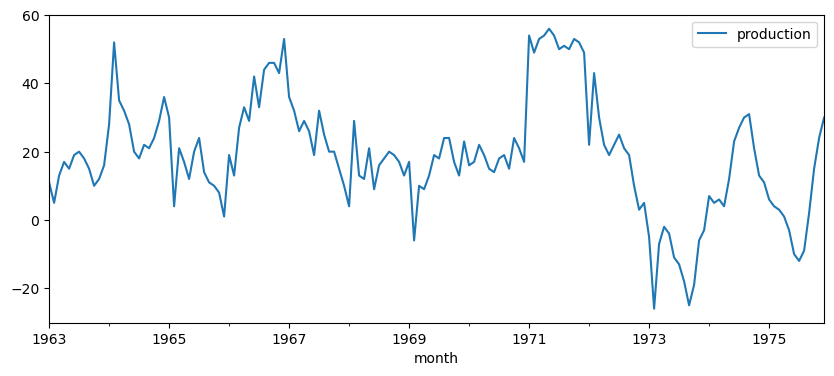

In [10]:
# Plot the deseasoned time series, which is not stationary yet. 

fig, ax = plt.subplots(figsize=(10, 4))
milk_diff_12.plot(ax=ax)
plt.show()

In [11]:
# After we removed the seasonal component, the time series is still non-stationary.
# We need to perform one more differencing to take care of the trend, and then check the stationarity again.

milk_diff_12_1 = milk_data.diff(12).diff(1).dropna()

adf = adfuller(milk_diff_12_1)[1:3]

if adf[0] < 0.05:
    print('Time series is stationary')
    print(f"p-value: {adf[0]}")
else:
    print('Time series is non-stationary')
    print(f"p-value: {adf[0]}")

Time series is stationary
p-value: 1.865423431878904e-05


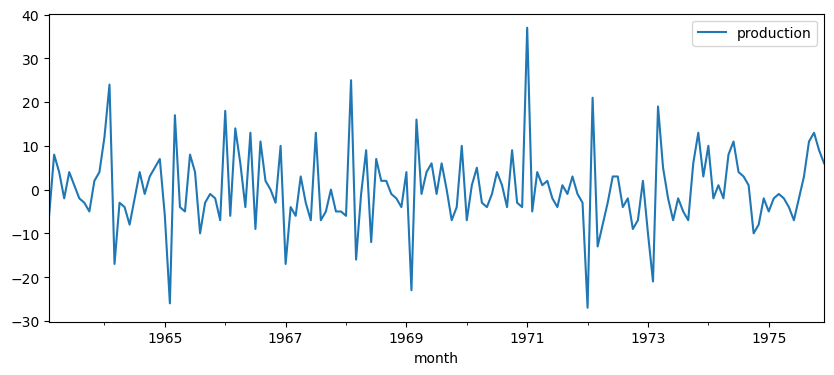

In [12]:
# Now the time series is stationary

fig, ax = plt.subplots(figsize=(10, 4))
milk_diff_12_1.plot(ax=ax)
plt.show()

# Assessing the hyperparameters for the arima model

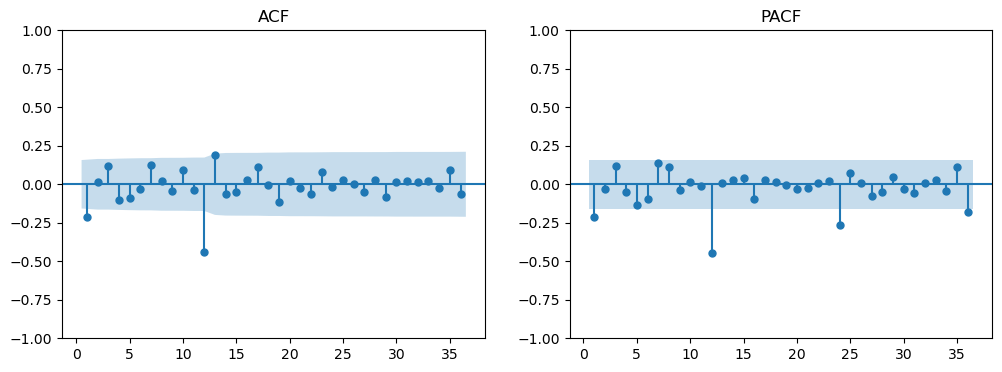

In [13]:
# Now when the time series is stationary, we can plot autocorrelation and partial autocorrelation functions to assess the hyperparameters
# to insert into the model.

fig, ax = plt.subplots(1,2, figsize=(12, 4))
plot_acf(milk_diff_12_1, zero=False, lags=36, ax=ax[0], title='ACF')
plot_pacf(milk_diff_12_1, zero=False, lags=36, ax=ax[1], title='PACF')
plt.show()

In [14]:
# Split the data into train and test subsets

from sklearn.model_selection import train_test_split

milk_train, milk_test = train_test_split(milk_data, test_size=0.1, shuffle=False)

#### Build the model

In [15]:
# Based on the ACF and PACF plots we select the arima order parameters as (0, 1, 1) for trend component, 
# and (0, 1, 1, 12) for seasonal component.

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(milk_train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model = sarima_model.fit(disp=0)

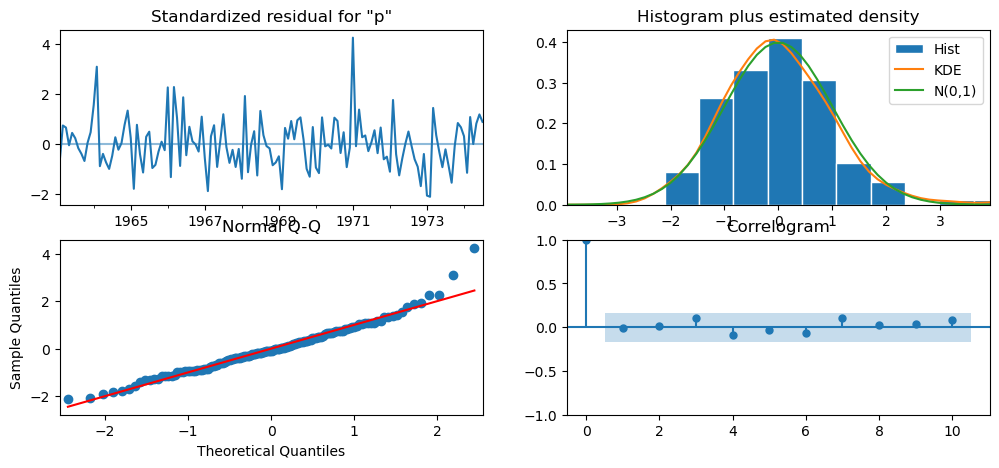

In [16]:
# To assess the quality of the model, we can check the residuals of the model. If the residuals of the model is very close to the white
# noise (Gaussian distribution), it indicates that the model captured all the predictable features of the time series data.
# The graphs below show that the residuals are close to the white noise.

model.plot_diagnostics(figsize=(12, 5))
plt.show()

In [17]:
# Here is the summary of the model with some statistics:

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  151
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -475.008
Date:                            Thu, 18 Jul 2024   AIC                            956.016
Time:                                    16:01:47   BIC                            964.798
Sample:                                01-01-1962   HQIC                           959.585
                                     - 07-01-1974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2714      0.082     -3.326      0.001      -0.431      -0.111
ma.S.L12      -0.6233      0.079     -7.908      0.000      -0.778      -0.469
sigma2        54.7638      5.498      9.960      0.000      43.987      65.540
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                31.78
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.74
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

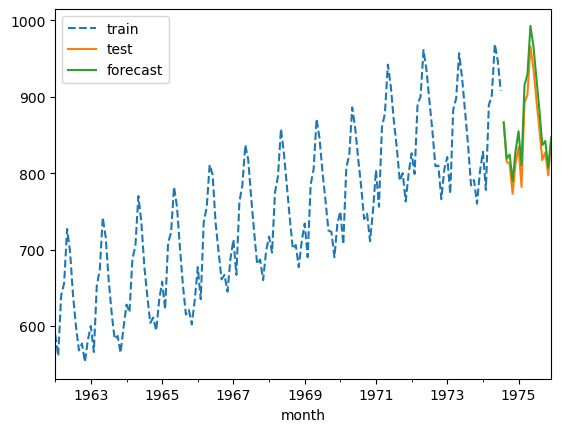

In [18]:
# Now we can use the model to forecast a few steps into the future and compare the predictions with the test data.

forecast = pd.DataFrame(model.forecast(milk_test.shape[0], index=milk_test.index))
ax = milk_train.loc[:].plot(style='--')
milk_test.plot(ax=ax)
forecast.plot(ax=ax)
ax.legend(['train', 'test', 'forecast'])
plt.show()                      

In [19]:
# Summary:
# As we can observe from the graph, the model did quite a good job of predicted time series values a few steps ahead. 
# The predicted values are very close to the unseen test dataset values. 